In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils

In [0]:
import numpy as np

In [0]:
from scipy.io import loadmat
train_X1 = loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14HZ, 0-800 (without csp)/train_X1.mat')['train_X1']
train_X2 = loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14HZ, 0-800 (without csp)/train_X2.mat')['train_X2']
test_X = loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14HZ, 0-800 (without csp)/test_X.mat')['test_X']
train_y = loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14HZ, 0-800 (without csp)/train_y.mat')['train_y']
test_y = loadmat('gdrive/My Drive/BCI_project/Band-passed 10-14HZ, 0-800 (without csp)/test_y.mat')['test_y']
train_X = np.concatenate((train_X1, train_X2), axis=2)

In [41]:
train_X = np.expand_dims(train_X, axis=0)
print(train_X.shape)
train_X = np.moveaxis(train_X, -1, 0)

test_X = np.expand_dims(test_X, axis=0)
test_X = np.moveaxis(test_X, -1, 0)

train_y = train_y.T
test_y = test_y.T
print("Dimensions of the train set:                 {}".format(train_X.shape))
print("Dimensions of the test set:                  {}".format(test_X.shape))

print("Dimensions of the labels for the train set:  {}".format(train_y.shape))
print("Dimensions of the labels for the test set:   {}".format(test_y.shape))

(1, 800, 39, 9601)
Dimensions of the train set:                 (9601, 1, 800, 39)
Dimensions of the test set:                  (2401, 1, 800, 39)
Dimensions of the labels for the train set:  (9601, 2)
Dimensions of the labels for the test set:   (2401, 2)


In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
transform = transforms.Compose([
    transforms.ToTensor()])

In [0]:
train_X = torch.tensor(train_X, dtype=torch.float)
test_X = torch.tensor(test_X, dtype=torch.float)

train_y = torch.tensor(train_y[:, 0], dtype=torch.float)
test_y = torch.tensor(test_y[:, 0], dtype=torch.float)

In [0]:
train_dataset = utils.TensorDataset(train_X, train_y)
test_dataset = utils.TensorDataset(test_X, test_y)

In [0]:
train_loader = utils.DataLoader(train_dataset, batch_size=128, num_workers=1)
test_loader = utils.DataLoader(test_dataset, batch_size=128, num_workers=1)

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, (1, 39))
        self.batch1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(0.5)
        self.conv2 = nn.Conv2d(8, 40, (25, 1), stride=25)
        self.batch2 = nn.BatchNorm2d(40)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 100)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 1)
        self._initialize_weights()
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.batch2(x)
        x = self.dropout2(x)
        x = x.view(-1, 40*32)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(1, 39), stride=(1, 1))
  (batch1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(8, 40, kernel_size=(25, 1), stride=(25, 25))
  (batch2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1280, out_features=100, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)

In [0]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters())
num_epochs = 30

In [50]:
losses = []
test_losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    test_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        labels = np.reshape(labels, (len(labels), 1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    losses.append(running_loss)
    print("%d epoch's train loss: %.3f" %
        (epoch + 1, running_loss))
    
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            labels = np.reshape(labels, (len(labels), 1))
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    print("%d epoch's test loss: %.3f" %
        (epoch + 1, test_loss))

    test_losses.append(test_loss)
                    
print('Finished Training')

1 epoch's train loss: 52.659
1 epoch's test loss: 13.143
2 epoch's train loss: 51.287
2 epoch's test loss: 12.842
3 epoch's train loss: 48.750
3 epoch's test loss: 12.559
4 epoch's train loss: 47.034
4 epoch's test loss: 12.293
5 epoch's train loss: 46.032
5 epoch's test loss: 12.197
6 epoch's train loss: 45.467
6 epoch's test loss: 11.945
7 epoch's train loss: 45.190
7 epoch's test loss: 11.950
8 epoch's train loss: 44.894
8 epoch's test loss: 11.867
9 epoch's train loss: 43.886
9 epoch's test loss: 11.888
10 epoch's train loss: 43.802
10 epoch's test loss: 11.708
11 epoch's train loss: 43.434
11 epoch's test loss: 11.654
12 epoch's train loss: 42.488
12 epoch's test loss: 11.846
13 epoch's train loss: 42.347
13 epoch's test loss: 11.629
14 epoch's train loss: 42.127
14 epoch's test loss: 11.716
15 epoch's train loss: 41.533
15 epoch's test loss: 11.661
16 epoch's train loss: 41.477
16 epoch's test loss: 11.492
17 epoch's train loss: 41.236
17 epoch's test loss: 11.446
18 epoch's trai

In [0]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [0]:
import matplotlib.pyplot as plt

No Skill AUC: 0.5
Our AUC: 0.784531955150763


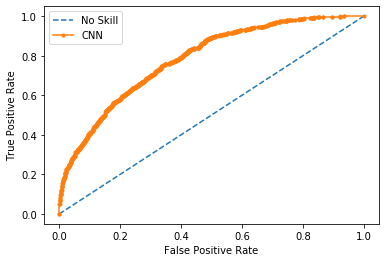

In [98]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
auc = 0
acc = 0
ns_probs = [0 for _ in range(len(test_loader.dataset))]
lr_probs = []
testy = []
with torch.no_grad():
    net.eval()
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        testy.extend(labels)
        lr_probs.extend(sigmoid(outputs.cpu().numpy()))

lr_probs = [x.item() for x in lr_probs]
testy = [x.item() for x in testy]

ns_auc = roc_auc_score(testy, ns_probs)
lr_auc = roc_auc_score(testy, lr_probs)
print("No Skill AUC: {}".format(ns_auc))
print("Our AUC: {}".format(lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='CNN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()


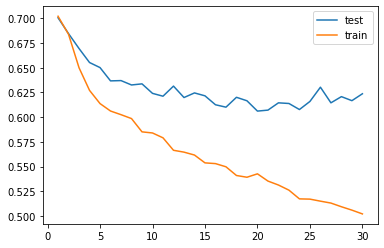

In [69]:
epochs = list(range(1,num_epochs+1))
plt.plot(epochs, [x / 18.76 for x in test_losses], label="test")
plt.plot(epochs, [x / 75 for x in losses], label="train")
plt.legend()
plt.show()